In [1]:
#IPython extension to reload modules before executing user code. If we make any change in function 
# and imoprting it we don't need to restart if we use auto reload 
%load_ext autoreload

# to print in between values as well without print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import json


# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import classification_report
from pprint import pprint as pp


# scipy
from scipy.stats import boxcox

# yellowbrick
from yellowbrick.classifier import ROCAUC

# Supporting Functions

In [32]:
# to save pickle file
def save_pkl_model(path,model):
    pickle.dump(model, open(path,'wb'))

In [33]:
# to load
def load_pkl_model(path):
    sc = pickle.load(open(path,'rb'))
    return sc

In [34]:
def preprocess_pipeline_1(test):
   
    # miss_num_imputer = load_pkl_model(missing_num_imputer_path)
    # missing_cat_imputer = load_pkl_model(missing_cat_imputer_path)
    ohe_converter = load_pkl_model(ohe_converter_path)
    num_transformer = load_pkl_model(mms_converter_path)

    # processing numeric
    num_cols = test.select_dtypes(include='number')
    num_column_names = num_cols.columns
    # num_miss_processed = miss_num_imputer.transform(num_cols)
    num_scalled = num_transformer.transform(num_cols)
    num_scalled_df = pd.DataFrame(num_scalled,columns=num_column_names)


    # processing categoric
    cat_cols = test.select_dtypes(include='O')
    # cat_miss_processed = missing_cat_imputer.transform(cat_cols)
    cat_encoded = ohe_converter.transform(cat_cols).toarray()
    cat_encoded_df = pd.DataFrame(cat_encoded,columns=ohe_converter.get_feature_names_out())


    # combine categoric and numeric data and return
    test_processed = pd.concat([num_scalled_df,cat_encoded_df],axis=1)
    
    return test_processed

In [113]:
def func_dropCol(df,column_elimination = ['SectionID',
                   'StageID',
                  'Semester']):
    for i in column_elimination:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
    return df

# Test and Analysis

## Load and Predict

In [114]:
# spacify saved preprocessing model paths
# missing_num_imputer_path = 'Data/processing_models/imputer_num.pkl'
# missing_cat_imputer_path = 'Data/processing_models/imputer_cat.pkl'
ohe_converter_path = 'Data/processing_models/ohe_converter.pkl'
mms_converter_path = 'Data/processing_models/mms_converter.pkl'

# Specify final ML model path
final_model_path = 'models/random_forest.pkl'


In [115]:
# load test data and check
test_data = pd.read_csv('Data/test.csv')
test_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Jordan,lowerlevel,G-02,A,French,S,Mum,25,80,29,23,No,Good,Under-7,M
1,M,KW,KuwaIT,MiddleSchool,G-07,A,Math,F,Father,11,2,2,8,No,Bad,Under-7,L
2,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,50,7,9,50,Yes,Bad,Above-7,M
3,M,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Father,10,8,10,10,Yes,Bad,Above-7,M
4,M,Iraq,Iraq,MiddleSchool,G-06,A,English,F,Mum,74,71,56,37,No,Good,Under-7,H


In [116]:
# devide Xtest ytest to compare
X_test,y_test = test_data.loc[:,~test_data.columns.isin(['Class'])],test_data['Class']

In [117]:
# preporcess the data for the model input
X_test_processed = preprocess_pipeline_1(X_test)
X_test_processed.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.25,0.808081,0.295918,0.224490,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,0.11,0.020202,0.020408,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.070707,0.091837,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.10,0.080808,0.102041,0.091837,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.74,0.717172,0.571429,0.367347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [118]:
# drop features not used
X_test_processed = func_dropCol(X_test_processed)
X_test_processed

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_History,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.25,0.808081,0.295918,0.224490,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.11,0.020202,0.020408,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.070707,0.091837,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.10,0.080808,0.102041,0.091837,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.74,0.717172,0.571429,0.367347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.55,0.727273,0.846939,0.132653,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
68,0.00,0.030303,0.102041,0.020408,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.70,0.696970,0.357143,0.295918,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
70,0.05,0.090909,0.193878,0.989796,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
# load the final model
final_model = load_pkl_model(final_model_path)

In [120]:
# prefict the model
y_pred = final_model.predict(X_test_processed)
y_pred

array([2, 1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1,
       2, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 1, 2, 0, 1, 1, 2, 2, 0, 1, 2, 0,
       1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 0, 1,
       0, 2, 1, 0, 1, 1], dtype=int64)

In [121]:
# load the json to convert from num to lable
with open('Data/processing_models/num_to_label.json') as json_file:
    num_to_label = json.load(json_file)

with open('Data/processing_models/label_to_num.json') as json_file:
    label_to_num = json.load(json_file)

num_to_label,label_to_num

({'0': 'H', '1': 'L', '2': 'M'}, {'H': 0, 'L': 1, 'M': 2})

In [122]:
y_pred = [num_to_label[str(i)] for i in y_pred]
y_pred

['M',
 'L',
 'L',
 'L',
 'H',
 'H',
 'M',
 'H',
 'M',
 'L',
 'H',
 'M',
 'L',
 'M',
 'L',
 'L',
 'M',
 'M',
 'M',
 'H',
 'L',
 'L',
 'M',
 'H',
 'M',
 'H',
 'H',
 'L',
 'M',
 'L',
 'M',
 'H',
 'H',
 'L',
 'M',
 'H',
 'L',
 'L',
 'M',
 'M',
 'H',
 'L',
 'M',
 'H',
 'L',
 'H',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'L',
 'M',
 'M',
 'M',
 'L',
 'H',
 'M',
 'L',
 'L',
 'M',
 'M',
 'L',
 'H',
 'L',
 'H',
 'M',
 'L',
 'H',
 'L',
 'L']

## Prediction Analysis

### a. Classification Report

In [123]:
# pp(classification_report(y_test,y_pred))
report = classification_report(y_test,y_pred,output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
H,0.833333,0.714286,0.769231,21.000000
L,0.760000,1.000000,0.863636,19.000000
M,0.793103,0.718750,0.754098,32.000000
accuracy,0.791667,0.791667,0.791667,0.791667
macro avg,0.795479,0.811012,0.795655,72.000000
weighted avg,0.796102,0.791667,0.787418,72.000000


### b. Confusion metrics

In [124]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred,labels=['L','M','H'])
cm

array([[19,  0,  0],
       [ 6, 23,  3],
       [ 0,  6, 15]], dtype=int64)

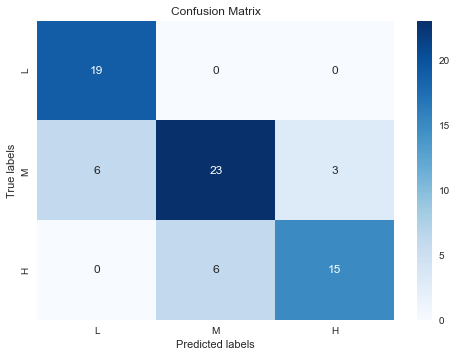

In [125]:
# sn.heatmap(cm, annot=True, cmap='Blues',xticklabels=['L','M','H'],yticklabels=['L','M','H'])

# plotting the values
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='d', ax=ax,cmap='Blues')  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['L','M','H']); ax.yaxis.set_ticklabels(['L','M','H']);

### ROC AUC curve

In [126]:
training_data = pd.read_csv('Data/transformed/train_mms_ohe.csv')
training_data['Class'] = training_data['Class'].apply(lambda x: label_to_num[x])
X_train,y_train = training_data.iloc[:,:-1],training_data.iloc[:,-1:]

In [127]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

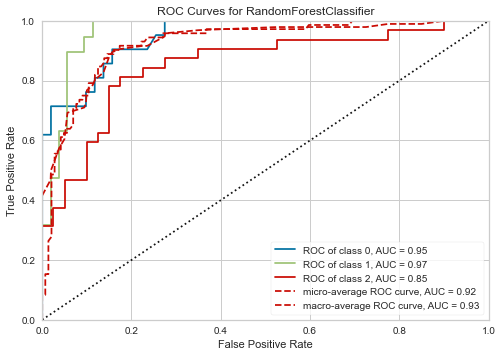

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=RandomForestClassifier(bootstrap=False, n_estimators=1200,
                                        random_state=0))

In [128]:
plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

In [129]:
label_to_num

{'H': 0, 'L': 1, 'M': 2}

### Save Test Results

In [130]:
test_data['predictions'] = y_pred
test_data.to_csv('test_results/test_pred_random_forest.csv',index=False)

### Analyse wrong predictions

In [131]:
test_data[test_data['Class']!=test_data['predictions']]

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class,predictions
2,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,50,7,9,50,Yes,Bad,Above-7,M,L
3,M,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Father,10,8,10,10,Yes,Bad,Above-7,M,L
8,M,KW,KuwaIT,lowerlevel,G-02,B,French,S,Mum,60,52,23,33,Yes,Good,Under-7,H,M
10,M,KW,KuwaIT,MiddleSchool,G-08,C,Spanish,S,Mum,57,51,46,34,Yes,Good,Under-7,M,H
16,F,lebanon,lebanon,lowerlevel,G-02,B,French,S,Mum,80,42,33,13,Yes,Bad,Under-7,H,M
21,M,SaudiArabia,SaudiArabia,lowerlevel,G-02,B,IT,F,Father,7,12,5,3,No,Bad,Above-7,M,L
23,F,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Mum,70,64,42,32,No,Bad,Under-7,M,H
29,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M,L
30,F,KW,KuwaIT,MiddleSchool,G-06,A,Science,S,Father,80,94,62,77,Yes,Good,Under-7,H,M
46,M,KW,KuwaIT,lowerlevel,G-02,B,French,S,Father,40,62,83,33,Yes,Good,Under-7,H,M


# Final Conclution 